## Import

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data from csv
talent = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
movie_info = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
movie_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
finance = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Clean and merge data

- Filter data to only include films from the past 10 years
- Eliminate null values from genre, averagerating, and any films that did not go to market (0 ROI)

In [3]:
#merge movie_info and movie_ratings
movies = movie_info.set_index('tconst').join(movie_ratings.set_index('tconst'))
movies = movies.reset_index()

movies['merge_id'] = movies['start_year'].astype(str) + movies['primary_title']

movies.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)


In [4]:
#clean finance data
finance['release_date'] = pd.to_datetime(finance['release_date'])
finance['release_date'] = pd.DatetimeIndex(finance['release_date']).year 

#convert money from string to integers
finance['production_budget'] = finance['production_budget'].str\
                               .replace(",","")
finance['production_budget'] = finance['production_budget'].str\
                               .replace("$","")
finance['production_budget'] = finance['production_budget'].astype(int)


finance['domestic_gross'] = finance['domestic_gross'].str\
                               .replace(",","")
finance['domestic_gross'] = finance['domestic_gross'].str\
                               .replace("$","")
finance['domestic_gross'] = finance['domestic_gross'].astype(int)

finance.drop(columns = ['id'], inplace = True)

In [5]:
#calculate ROI and create ROI column 
finance['roi'] = finance['domestic_gross'] / finance['production_budget']

In [6]:
#create common id to merge movie and finance info
finance['merge_id'] = finance['release_date'].astype(str) + finance['movie']

In [7]:
#merge movies and finance dataframes
movies_df = finance.set_index('merge_id').join(movies.set_index('merge_id'))
movies_df = movies_df.reset_index()

In [8]:
#explode genres
movies_df['genres'] = movies_df['genres'].str.split(",")
movies_df = movies_df.explode('genres')

In [9]:
#drop null values, movies that did not enter the market (0 ROI), movies made in the past 10 years
movies_df = movies_df[movies_df['roi'] !=0]

movies_df = movies_df.dropna(subset = ['genres','averagerating'])

movies_df = movies_df[movies_df['release_date']>2010]

In [10]:
movies_df

,merge_id,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi,tconst,primary_title,start_year,genres,averagerating,numvotes
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Action,6.1,87254.0
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Comedy,6.1,87254.0
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Crime,6.1,87254.0
3872,20115 Days of War,2011,5 Days of War,12000000,17479,"$87,793",0.001457,tt1486193,5 Days of War,2011.0,Action,5.6,13089.0
3872,20115 Days of War,2011,5 Days of War,12000000,17479,"$87,793",0.001457,tt1486193,5 Days of War,2011.0,Drama,5.6,13089.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019What Men Want,2019,What Men Want,20000000,54611903,"$69,911,903",2.730595,tt7634968,What Men Want,2019.0,Fantasy,4.9,10141.0
5840,2019What Men Want,2019,What Men Want,20000000,54611903,"$69,911,903",2.730595,tt7634968,What Men Want,2019.0,Romance,4.9,10141.0
5841,2019Wonder Park,2019,Wonder Park,100000000,45216793,"$115,149,422",0.452168,tt6428676,Wonder Park,2019.0,Adventure,5.7,3091.0
5841,2019Wonder Park,2019,Wonder Park,100000000,45216793,"$115,149,422",0.452168,tt6428676,Wonder Park,2019.0,Animation,5.7,3091.0


## ROI by Genre

In [11]:
genres = movies_df.groupby(by=['genres']).describe()

In [12]:
roi = genres['roi'].sort_values(by='count', ascending = False)

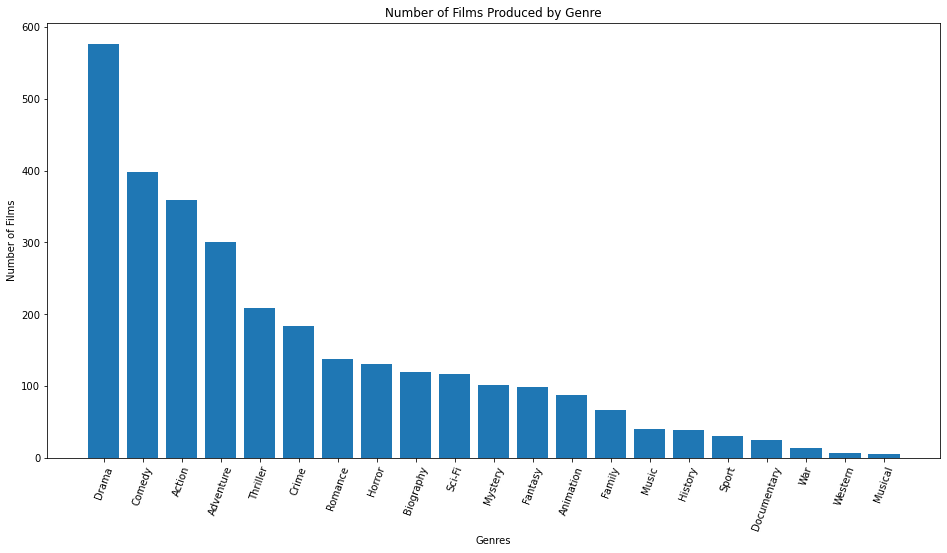

In [13]:
#Graph the number of films produced by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(roi.index)
y = list(roi['count'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('Number of Films')
ax.set_title('Number of Films Produced by Genre')
plt.xticks(rotation = 70)
plt.show()

In [14]:
#Graph ROI by genre
roi = roi.sort_values(by='50%', ascending = False)

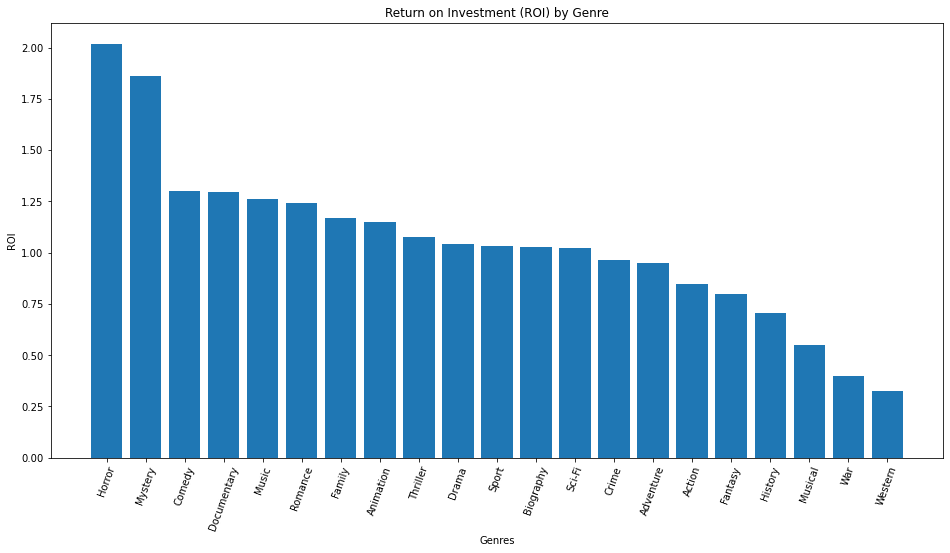

In [15]:
#Graph genre by ROI [median]
fig, ax = plt.subplots(figsize = (16, 8))

x = list(roi.index)
y = list(roi['50%'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('ROI')
ax.set_title('Return on Investment (ROI) by Genre')
plt.xticks(rotation = 70)
plt.show()

In [16]:
ratings = genres['averagerating'].sort_values(by='mean', ascending = False)

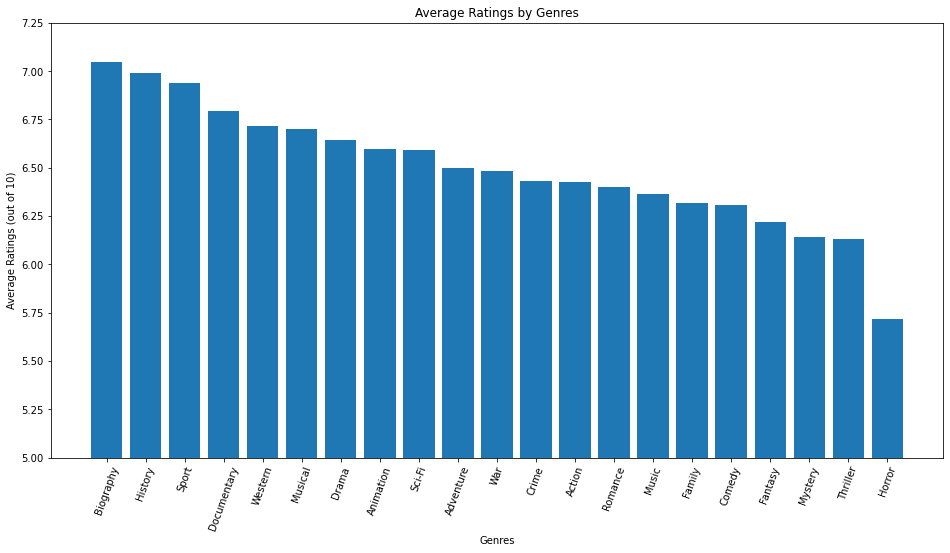

In [17]:
#Graph rating by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(ratings.index)
y = list(ratings['mean'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Ratings (out of 10)')
ax.set_title('Average Ratings by Genres')
plt.ylim(5, 7.25)
plt.xticks(rotation = 70)
plt.show()

## Budget

In [18]:
#relationship between metrics
movies_df.corr()

,release_date,production_budget,domestic_gross,roi,start_year,averagerating,numvotes
release_date,1.000000,0.053745,0.085714,0.026029,1.000000,-0.009073,-0.148538
production_budget,0.053745,1.000000,0.690620,-0.092511,0.053745,0.195878,0.534730
domestic_gross,0.085714,0.690620,1.000000,0.044731,0.085714,0.326357,0.659750
roi,0.026029,-0.092511,0.044731,1.000000,0.026029,-0.040787,0.014913
start_year,1.000000,0.053745,0.085714,0.026029,1.000000,-0.009073,-0.148538
averagerating,-0.009073,0.195878,0.326357,-0.040787,-0.009073,1.000000,0.514689
numvotes,-0.148538,0.534730,0.659750,0.014913,-0.148538,0.514689,1.000000


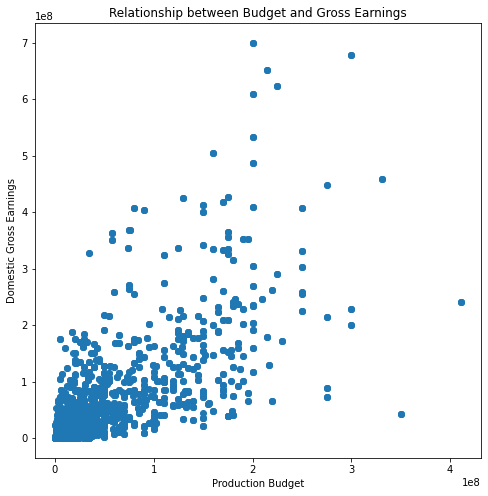

In [19]:
#Graph rating by genre
fig, ax = plt.subplots(figsize = (8, 8))

x = movies_df['production_budget']
y = movies_df['domestic_gross']

plt.scatter(x, y)
ax.set_xlabel('Production Budget')
ax.set_ylabel('Domestic Gross Earnings')
ax.set_title('Relationship between Budget and Gross Earnings')
#plt.ylim(5, 7.25)
#plt.xticks(rotation = 70)
plt.show()

In [20]:
#Median Production Budget 2750000
movies_df[movies_df['genres']=='Documentary'].describe()

,release_date,production_budget,domestic_gross,roi,start_year,averagerating,numvotes
count,24.000000,2.400000e+01,2.400000e+01,24.000000,24.000000,24.000000,24.00000
mean,2013.708333,1.133271e+07,1.303669e+07,2.314607,2013.708333,6.791667,5908.12500
std,2.115762,2.997514e+07,1.953673e+07,3.307297,2.115762,1.328260,15255.04307
min,2011.000000,5.000000e+04,1.822000e+03,0.003644,2011.000000,1.600000,12.00000
25%,2012.000000,5.450000e+05,1.316428e+05,0.146317,2012.000000,6.650000,62.50000
50%,2014.000000,2.750000e+06,5.060406e+06,1.294253,2014.000000,7.000000,459.00000
75%,2015.000000,1.050000e+07,1.675928e+07,2.564288,2015.000000,7.500000,6056.75000
max,2018.000000,1.500000e+08,7.301391e+07,12.897620,2018.000000,8.400000,74978.00000


## Talent

In [21]:
#drop rows that did not include professions or title
talent = talent.dropna(subset=['primary_profession', 'known_for_titles'])

In [22]:
#Explode professions and known films
talent['primary_profession']=talent['primary_profession'].str.split(",")
talent['known_for_titles']=talent['known_for_titles'].str.split(",")

In [23]:
talent = talent.explode('primary_profession')

In [24]:
talent = talent.explode('known_for_titles')

In [25]:
#Join movie dataframe with the talent dataframe
talent = talent.set_index('known_for_titles').join(movies_df.set_index('tconst'))
talent = talent.reset_index()

In [26]:
#clean table by dropping null values from metrics needed for analysis
talent = talent.dropna(subset=['roi', 'genres', 'averagerating','primary_profession'])

In [27]:
talent = talent.drop(columns = ['birth_year', 'death_year',
       'merge_id', 'release_date', 'movie',
       'worldwide_gross', 'start_year', 'numvotes'])

In [36]:
doc_directors = talent[(talent['genres']=='Documentary') & \
                       (talent['primary_profession']=='director')]\
                       .sort_values(by='roi', ascending=False)
doc_directors

,index,nconst,primary_name,primary_profession,production_budget,domestic_gross,roi,primary_title,genres,averagerating
1206025,tt1702443,nm0160840,Jon M. Chu,director,13000000.0,73013910.0,5.616455,Justin Bieber: Never Say Never,Documentary,1.6
1206035,tt1702443,nm3708437,Sebastian Podesta,director,13000000.0,73013910.0,5.616455,Justin Bieber: Never Say Never,Documentary,1.6
1274564,tt1781784,nm0701245,Tom Putnam,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1274569,tt1781784,nm2198644,Brenna Sanchez,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1274573,tt1781784,nm1890918,Mark Eaton,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1938928,tt2926868,nm4991030,Reber Dosky,director,12800000.0,51872378.0,4.052530,The Call,Documentary,7.9
3010890,tt6184774,nm3901669,Van Royko,director,3000000.0,7233471.0,2.411157,Let There Be Light,Documentary,6.7
3010888,tt6184774,nm1117383,Mila Aung-Thwin,director,3000000.0,7233471.0,2.411157,Let There Be Light,Documentary,6.7
1424967,tt1976608,nm0233771,Joseph Dorman,director,500000.0,1131261.0,2.262522,Sholem Aleichem: Laughing in the Darkness,Documentary,6.8
1595803,tt2215719,nm5061089,Edward Lovelace,director,12000000.0,25326071.0,2.110506,Katy Perry: Part of Me,Documentary,5.9
